# Data Preprocessing

## Merging All of the Data

Because we want to be able to have control over how much of the data gets split into train, test, and validation sets, we should get a list of all of the files and keep track of which are images classified as PNEUMONIA and which are classified as NORMAL.

In [1]:
from glob import glob
import pandas as pd
import os
from skimage.io import imread, imsave
from skimage import img_as_ubyte
from matplotlib import pyplot as plt
from PIL import UnidentifiedImageError
from tqdm import tqdm
import numpy as np
from galaxyteam.dataset import resize_image

In [2]:
data_directory = os.path.abspath('./data/') + '/'
xray_directory = data_directory + 'chest_xray/chest_xray/'
all_files = glob(xray_directory + '*/*/*')

preprocessed_dir = data_directory + 'preprocessed/'
os.makedirs(preprocessed_dir, exist_ok=True)

In [3]:
file_data = pd.DataFrame(all_files, columns=['orig_file_path'])
file_data['is_pneumonia'] = file_data['orig_file_path'].str.contains('/PNEUMONIA/')

In [4]:
file_data.head()

,orig_file_path,is_pneumonia
0,/home/adam/Documents/GalaxyTeam/notebooks/data...,True
1,/home/adam/Documents/GalaxyTeam/notebooks/data...,True
2,/home/adam/Documents/GalaxyTeam/notebooks/data...,True
3,/home/adam/Documents/GalaxyTeam/notebooks/data...,True
4,/home/adam/Documents/GalaxyTeam/notebooks/data...,True


## Custom Train/Test Splitting

We can now split the data into train and test sets, and we will reserve splitting off the validation split for when a particular model is run.  This way, we still have the flexibility to generate a standard validation set or perform cross-validation as needed.

In [5]:
# Note that this also shuffles the data just in case we forget later...
train_file_data = file_data.sample(frac=0.8, random_state=1337)
test_file_data = file_data.drop(train_file_data.index)

print(f'There are {len(train_file_data)} elements in the training set.')
print(f'There are {len(test_file_data)} elements in the test set.')

There are 4685 elements in the training set.
There are 1171 elements in the test set.


## Preprocessing the Images

Most models we apply to these images are going to require that the images all have the same shape.  Let's start by seeing what typical image dimensions look like.

In [6]:
image_dims = []

for image_fname in tqdm(file_data['orig_file_path']):
    try:
        image_dims.append(imread(image_fname).shape)
    except UnidentifiedImageError:
        print(image_fname + ' unreadable.')

100%|████████████████████████████████████████████████████| 5856/5856 [00:51<00:00, 112.97it/s]


### Image Dimensions

As we can see below, some of the images are two-dimensional (grayscale) while others are three-dimensional (color).  We'll want to add a color dimension to the grayscale images so that they match the rest

In [7]:
count = 0
all_image_dims  = []
for x, dims in enumerate(image_dims):
    if len(dims) != 2:
        count += 1
        all_image_dims.append(dims[:2])
    else:
        all_image_dims.append(dims)

all_image_dims = np.array(all_image_dims)
        
print(f'There are {count} images in color and {len(image_dims)-count} images in B+W.')

There are 283 images in color and 5573 images in B+W.


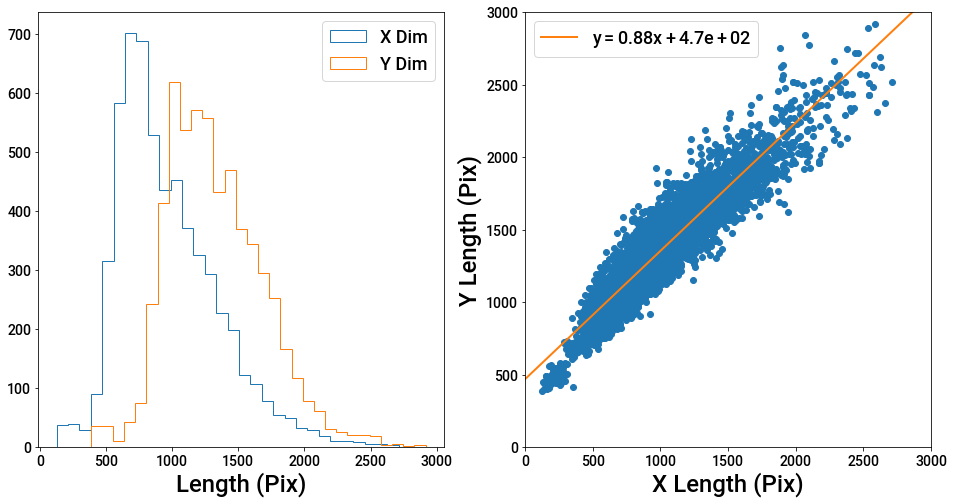

In [8]:
fig = plt.figure(figsize=(16, 8))
sp1 = fig.add_subplot(121)
sp2 = fig.add_subplot(122)

sp1.hist(all_image_dims.T[0], bins=30, histtype='step', label='X Dim')
sp1.hist(all_image_dims.T[1], bins=30, histtype='step', label='Y Dim')

sp2.scatter(all_image_dims.T[0], all_image_dims.T[1])

linefunc = np.poly1d(np.polyfit(all_image_dims.T[0], all_image_dims.T[1], 1))
xgrid = np.linspace(0, 3000, 100)
sp2.plot(xgrid, linefunc(xgrid), c='C1', label = f'$y={linefunc.c[0]:.2}x + {linefunc.c[1]:.2}$')

sp1.set_xlabel('Length (Pix)')
sp1.legend()

sp2.set_xlabel('X Length (Pix)')
sp2.set_ylabel('Y Length (Pix)')
sp2.set_xlim(0, 3000)
sp2.set_ylim(0,3000)
sp2.legend()


Here, it appears that the images have an aspect ratio that is slightly less than 1.  We will resize the images to be **224x224** because this is required by the RESNET architecture.

### Resizing the Images

In [9]:
train_fp_list = []
test_fp_list = []

# Make the save folder if it doesn't already exist.
os.makedirs(preprocessed_dir + '/resized/train/', exist_ok=True)
os.makedirs(preprocessed_dir + '/resized/test/', exist_ok=True)

## The save_file lines in here simply create test and train folders within
## preprocessed_dir with the NORMAL and PNEUMONIA folders like the original data
for train_file in tqdm(train_file_data.orig_file_path):
    image = imread(train_file)
    save_file = preprocessed_dir + '/resized/train/' + '/'.join(train_file.split('/')[-2:])
    train_fp_list.append(save_file)
    resized = resize_image(image, target_shape=(224, 224, 3))
    imsave(save_file, img_as_ubyte(resized))

for test_file in tqdm(test_file_data.orig_file_path):
    image = imread(test_file)
    save_file = preprocessed_dir + '/resized/test/' + '/'.join(test_file.split('/')[-2:])
    test_fp_list.append(save_file)
    resized = resize_image(image, target_shape=(224, 224, 3))
    imsave(save_file, img_as_ubyte(resized))

100%|█████████████████████████████████████████████████████| 1171/1171 [00:36<00:00, 31.92it/s]


In [10]:
train_file_data['resized_file_path'] = train_fp_list
test_file_data['resized_file_path'] = test_fp_list

## Saving the Metadata

We can now save these records of which files belong in each set in case we need to reference them in the future...

In [11]:
# We can go ahead and leave out the index because the file order in glob doesn't really matter
train_file_data.to_csv(preprocessed_dir + 'train_metadata.csv', index=False)
test_file_data.to_csv(preprocessed_dir + 'test_metadata.csv', index=False)